In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import sys
sys.path.append(os.path.join(os.path.dirname('__file__'), '../selfscat/'))
from xsect_majorana_tch import *
from phase_shift import *

GeVinvTocm = 0.197e-13
GeVtogram = 1.78e-24
c = 3e5 #km/s
unit_converter = GeVinvTocm**2/GeVtogram

plt.rcParams['axes.linewidth'] = 1.3
plt.rcParams['xtick.direction'] = 'in'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.3#x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.3#y軸主目盛り線の線幅
plt.rcParams['xtick.major.size'] = 7.0
plt.rcParams['ytick.major.size'] = 7.0
plt.rcParams['xtick.minor.width'] = 1.3#x軸主目盛り線の線幅
plt.rcParams['ytick.minor.width'] =1.3#y軸主目盛り線の線幅
plt.rcParams['xtick.minor.size'] = 4.0#x軸主目盛り線の線幅
plt.rcParams['ytick.minor.size'] = 4.0
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] =0.1

In [2]:
def xsect_k2_dirac(a, b, sign, tol=1e-2, eval_L=2, max_L=10,
                method='RK45', tol_convergence=0.01, max_itr=10000,
                xtol_root=1e-4, rtol_root=1e-4,
                atol_ode=1e-4, rtol_ode=1e-5, verbose=False):
    
    '''
    Return sigma_T*k^2/4pi
    '''

    other_params = (method, tol_convergence, max_itr, xtol_root, rtol_root, atol_ode, rtol_ode)
    
    L = 0
    delta_arr = [phase_shift(a, b, L, sign, *other_params)]
    
    xsect_k2_arr = [0.0]
    
    for L in range(1, max_L+1, 1):
        delta_arr.append(phase_shift(a, b, L, sign, *other_params))
        xsect_k2 = xsect_k2_arr[L-1] + L*np.sin(delta_arr[L] - delta_arr[L-1])**2
        xsect_k2_arr.append(xsect_k2)
        if verbose and L % 10 == 0:
            print(L, xsect_k2, delta_arr[-1])
        
        if L >= eval_L:
            err = np.abs(xsect_k2/xsect_k2_arr[-2] - 1)
            if err < tol and np.abs(delta_arr[-1]) < tol:
                break
        
    return delta_arr, xsect_k2_arr, L

In [3]:
def xsectm_clas_dirac(a, b, alphaX,  sign):
    """
    classical formula (1512.05344) valid for mX*v >> mphi.
    I have multiplied factor 0.25 (majorana_factor) to match the result of partial wave expansion.
    """
    beta = 1.0/2.0/a**2/b
    prefactor = b**2/alphaX**2
    if sign > 0:
        # attractive
        if beta < 1e-2:
            return prefactor * 2*np.pi * beta**2 * np.log(1 + 1.0/beta**2)
        elif beta < 1e2:
            return prefactor * 7*np.pi * (beta**1.8 + 280*(beta/10)**10.3) / (1.0 + 1.4*beta + 0.006*beta**4 + 160.0*(beta/10.0)**10)
        else: 
            return prefactor * 0.81*np.pi * (1.0 + np.log(beta) - 1.0/2.0/np.log(beta))**2

In [4]:
alphaX = 1e-2
sign = 1.0
b = 4.52

vs = np.logspace(0, 4, 40)/c
sigmam2 = []
for v in vs:
    a = v/2/alphaX
    res = xsect_k2_dirac(a, b, sign, max_L=100, eval_L=2)
    tmp = res[1][-1]*16*np.pi/v**2 * unit_converter
    print(v*c, tmp, res[-1])
    sigmam2.append(tmp)

/Users/yanagi/.pyenv/versions/3.7.4/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `jac`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


1.0 4.760740834463512 2
1.2663801734674032 4.760315150303522 2
1.6037187437513303 4.7596401343285075 2
2.0309176209047357 4.758569229237204 2
2.571913809059345 4.756870759595421 2
3.257020655659783 4.7541754699483985 2
4.1246263829013525 4.749765997705123 2
5.223345074266842 4.7428821580068155 2
6.614740641230149 4.732071586348952 2
8.376776400682918 4.71501229754072 2
10.608183551394482 4.6880503257736885 2
13.433993325989 4.645491112553476 2
17.012542798525892 4.578494473783315 2
21.54434690031883 4.47349746226129 2
27.28333376486768 4.3103533739590665 2
34.55107294592218 4.060191778716163 2
43.75479375074185 3.6851829720699456 2
55.41020330009492 3.1453500218624786 3
70.17038286703826 2.425391686856148 3
88.86238162743403 1.6166134887812567 3
112.53355826007646 1.1343748398899092 3
142.5102670302998 2.2419526651747055 3
180.47217668271705 8.223963093270184 3
228.54638641349908 26.752598078788306 3
289.4266124716752 73.97939673545162 3
366.52412370796264 179.51080369025232 3
464.1588

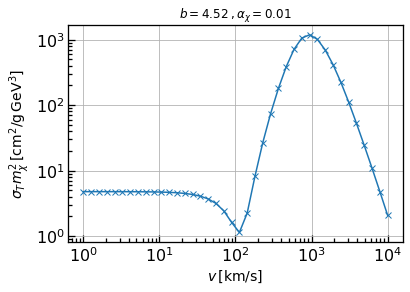

In [5]:
plt.plot(vs*c, sigmam2, "x-")
plt.loglog()

plt.xlabel('$v\\,\\mathrm{[km/s]}$', fontsize=14)
plt.ylabel(r'$\sigma_T m_\chi^2\,\mathrm{[cm^2/g\, GeV^3]}$', fontsize=14)
plt.title(r'$b={}\,, \alpha_\chi={}$'.format(b, alphaX))
plt.grid(True)
#plt.savefig('../plot/dirac_1.pdf', transparent=True)

In [6]:
alphaX = 1e-2
sign = 1.0
b = 17.6

vs = np.logspace(0, 4, 30)/c
sigmam2 = ([])
for v in vs:
    a = v/2/alphaX
    res = xsect_k2_dirac(a, b, sign, max_L=100, eval_L=2)
    tmp = res[1][-1]*16*np.pi/v**2 * unit_converter
    print(v*c, tmp, res[-1])
    sigmam2 = np.append(sigmam2, tmp)

1.0 134465.06360063198 2
1.373823795883263 134588.43748640874 2
1.887391822135097 134822.24747717427 2
2.592943797404667 135267.2275427604 2
3.562247890262442 136120.62729744712 2
4.893900918477494 137781.92179869072 2
6.7233575364993365 141109.47260905782 2
9.23670857187386 148154.26450164273 2
12.689610031679221 164820.4580001863 3
17.43328822199988 214865.63697697493 3
23.95026619987486 491169.9867482692 3
32.90344562312668 2295234.2424700297 3
45.20353656360243 252045.69243688066 3
62.10169418915616 132529.38644601087 3
85.31678524172806 102552.74537163929 3
117.21022975334806 86474.05577567733 3
161.02620275609394 75282.19928962455 4
221.2216291070448 67497.1236431595 4
303.91953823131985 40311.67604734571 5
417.53189365604 28498.54947583545 7
573.6152510448682 19812.7906483263 8
788.0462815669912 10918.51158454056 10
1082.636733874054 5012.684350229549 12
1487.3521072935118 2055.191609022659 14
2043.3597178569416 784.5548673623073 17
2807.2162039411755 282.74811903642336 20
3856.

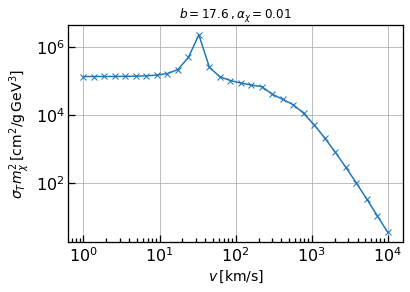

In [7]:
plt.plot(vs*c, sigmam2, "x-")
plt.loglog()
plt.xlabel('$v\\,\\mathrm{[km/s]}$', fontsize=14)
plt.ylabel(r'$\sigma_T m_\chi^2\,\mathrm{[cm^2/g\, GeV^3]}$', fontsize=14)
plt.title(r'$b={}\,, \alpha_\chi={}$'.format(b, alphaX))
plt.grid(True)
#plt.savefig('../plot/dirac_2.pdf', transparent=True)

In [12]:
alphaX = 1e-2
sign = 1.0
b = 57.5

vs = np.logspace(0, 3.5, 30)/c
sigmam2 = np.array([])
for v in vs:
    a = v/2/alphaX
    res = xsect_k2_dirac(a, b, sign, max_L=100, eval_L=2)
    tmp = res[1][-1]*16*np.pi/v**2 * unit_converter
    print(v*c, tmp, res[-1])
    sigmam2 = np.append(sigmam2, tmp)

1.0 70492270.1637631 2
1.3203517797162951 67686622.74012212 2
1.743328822199988 63287464.80321217 2
2.301807313022467 56827898.8613814 2
3.0391953823131974 48202175.6554365 2
4.012807031942776 38035025.83844934 2
5.298316906283709 27670947.95630793 2
6.995642156712631 18551119.180356592 2
9.236708571873864 11494584.146696474 2
12.195704601594414 6539280.826054174 2
16.102620275609393 3289648.942782741 3
21.261123338996565 1376075.2060843115 3
28.072162039411772 686481.4728318002 3
37.065129109221566 612717.644862489 4
48.93900918477493 403508.6074767671 4
64.61670787466973 253438.3883037999 5
85.3167852417281 186576.1401997123 6
112.64816923358867 390499.5513871375 7
148.73521072935117 156556.70314966037 9
196.382800192977 185878.09251795273 11
259.2943797404667 243141.1834534965 13
342.35979576075835 187398.21849743376 16
452.0353656360245 108716.84255402132 19
596.845699512231 54663.12403868524 22
788.0462815669912 25250.994101634715 26
1040.4983103657853 11022.792906752973 30
1373.8

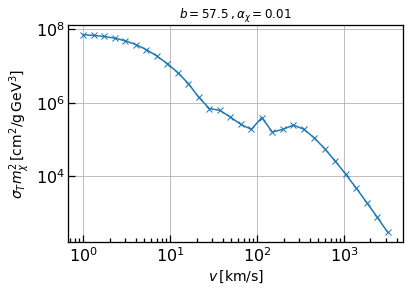

In [13]:
plt.plot(vs*c, sigmam2, "x-")
plt.loglog()
plt.xlabel('$v\\,\\mathrm{[km/s]}$', fontsize=14)
plt.ylabel(r'$\sigma_T m_\chi^2\,\mathrm{[cm^2/g\, GeV^3]}$', fontsize=14)
plt.title(r'$b={}\,, \alpha_\chi={}$'.format(b, alphaX))
plt.grid(True)
#plt.savefig('../plot/dirac_3.pdf', transparent=True)

In [14]:
alphaX = 1e-2
sign = 1.0
b = 1000

vs = np.logspace(0, 2.5, 30)/c
sigmam2 = np.array([])
for v in vs:
    a = v/2/alphaX
    res = xsect_k2_dirac(a, b, sign, max_L=1000, eval_L=2, tol=0.01)
    tmp = res[1][-1]*16*np.pi/v**2 * unit_converter
    print(v*c, tmp, res[-1])
    sigmam2 = np.append(sigmam2, tmp)

1.0 1961006036.2499974 4
1.219570460159441 1910108779.2776341 4
1.4873521072935114 1821364370.723859 4
1.8139306939110624 1156672818.2672875 4
2.2122162910704493 785006402.441108 5
2.697953640073 542849986.1258804 5
3.2903445623126686 343987595.53332615 6
4.012807031942776 229169500.34110123 8
4.893900918477494 174223397.05922404 8
5.9684569951223105 162587258.99741605 10
7.278953843983151 258986919.7884328 11
8.877197088985865 275890274.3633906 13
10.826367338740546 183276964.6864375 15
13.203517797162956 177340177.16190264 18
16.102620275609393 174755664.8727847 21
19.6382800192977 130524296.0962413 24
23.95026619987486 141400555.7513918 28
29.2090371703225 94757188.42115928 32
35.622478902624444 85702386.3367574 37
43.44412298729367 69547838.71080902 43
52.98316906283709 69058090.2749209 49
64.61670787466973 73322933.49151403 56
78.80462815669911 60587507.67265023 64
96.10779662375923 42821870.143137895 73
117.21022975334806 27554374.64808143 83


../selfscat/phase_shift.py:51: RuntimeWarning: overflow encountered in double_scalars
  bl = xf*sol.y[1][-1]/sol.y[0][-1] - 1.0
../selfscat/phase_shift.py:53: RuntimeWarning: invalid value encountered in double_scalars
  /(a*xf*spherical_yn(l,a*xf,derivative=True) - bl*spherical_yn(l,a*xf, derivative=False))
/Users/yanagi/.pyenv/versions/3.7.4/lib/python3.7/site-packages/scipy/integrate/_ivp/rk.py:65: RuntimeWarning: overflow encountered in add
  K[s] = fun(t + c * h, y + dy)
/Users/yanagi/.pyenv/versions/3.7.4/lib/python3.7/site-packages/scipy/integrate/_ivp/rk.py:67: RuntimeWarning: overflow encountered in add
  y_new = y + h * np.dot(K[:-1].T, B)
/Users/yanagi/.pyenv/versions/3.7.4/lib/python3.7/site-packages/scipy/integrate/_ivp/rk.py:110: RuntimeWarning: invalid value encountered in true_divide
  return norm(self._estimate_error(K, h) / scale)


142.94613383568455 16680477.069693007 93
174.33288221999894 9677949.054233165 104
212.6112333899658 5441847.534164906 116
259.2943797404667 2987124.6834848193 128
316.22776601683796 1608828.0182662287 141


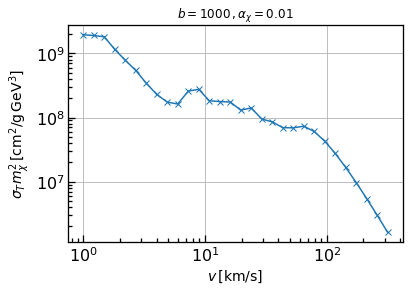

In [15]:
plt.plot(vs*c, sigmam2, "x-")
plt.loglog()
plt.xlabel('$v\\,\\mathrm{[km/s]}$', fontsize=14)
plt.ylabel(r'$\sigma_T m_\chi^2\,\mathrm{[cm^2/g\, GeV^3]}$', fontsize=14)
plt.title(r'$b={}\,, \alpha_\chi={}$'.format(b, alphaX))
plt.grid(True)
#plt.savefig('../plot/dirac_4.pdf', transparent=True)

In [16]:
alphaX = 1e-2
sign = 1.0
b = 1.68

vs = np.logspace(0, 4, 30)/c
sigmam2 = np.array([])
for v in vs:
    a = v/2/alphaX
    res = xsect_k2_dirac(a, b, sign, max_L=100, eval_L=2)
    tmp = res[1][-1]*16*np.pi/v**2 * unit_converter
    print(v*c, tmp, res[-1])
    sigmam2 = np.append(sigmam2, tmp)

1.0 906375371.2791777 2
1.373823795883263 499296373.3130086 2
1.887391822135097 270228342.2003792 2
2.592943797404667 144824527.66701493 2
3.562247890262442 77203699.69276422 2
4.893900918477494 41038423.007021174 2
6.7233575364993365 21781078.535388786 2
9.23670857187386 11550864.994053038 2
12.689610031679221 6122952.868589706 2
17.43328822199988 3244930.1782725635 2
23.95026619987486 1719460.4154596566 2
32.90344562312668 911049.0700353005 2
45.20353656360243 482679.6602583933 2
62.10169418915616 255702.66230959995 2
85.31678524172806 135439.34128550446 2
117.21022975334806 71719.01323705276 2
161.02620275609394 37957.73900687517 2
221.2216291070448 20069.974954737918 2
303.91953823131985 10592.625292006132 2
417.53189365604 5571.505600115933 2
573.6152510448682 2911.6419536683784 2
788.0462815669912 1503.256018468655 2
1082.636733874054 758.8364787161934 2
1487.3521072935118 368.03293044432934 2
2043.3597178569416 167.55333670782497 3
2807.2162039411755 70.4524137644612 3
3856.6204

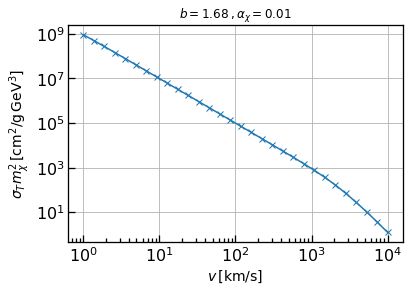

In [17]:
plt.plot(vs*c, sigmam2, "x-")
plt.loglog()
plt.xlabel('$v\\,\\mathrm{[km/s]}$', fontsize=14)
plt.ylabel(r'$\sigma_T m_\chi^2\,\mathrm{[cm^2/g\, GeV^3]}$', fontsize=14)
plt.title(r'$b={}\,, \alpha_\chi={}$'.format(b, alphaX))
plt.grid(True)
#plt.savefig('../plot/dirac_5.pdf', transparent=True)

In [18]:
alphaX = 1e-2
sign = 1.0
b = 1.53

vs = np.logspace(0, 4, 30)/c
sigmam2 = np.array([])
for v in vs:
    a = v/2/alphaX
    res = xsect_k2_dirac(a, b, sign, max_L=100, eval_L=2)
    tmp = res[1][-1]*16*np.pi/v**2 * unit_converter
    print(v*c, tmp, res[-1])
    sigmam2 = np.append(sigmam2, tmp)

1.0 12833.2611619273 2
1.373823795883263 12833.086682236202 2
1.887391822135097 12832.757581739934 2
2.592943797404667 12832.136662182917 2
3.562247890262442 12830.965152284194 2
4.893900918477494 12828.755026735795 2
6.7233575364993365 12824.58643228877 2
9.23670857187386 12816.720648584936 2
12.689610031679221 12801.905785921408 2
17.43328822199988 12774.056025126823 2
23.95026619987486 12721.836483004432 2
32.90344562312668 12624.44721333739 2
45.20353656360243 12444.653153530551 2
62.10169418915616 12118.888996110867 2
85.31678524172806 11548.206722328976 2
117.21022975334806 10605.072560925828 2
161.02620275609394 9187.130229878248 2
221.2216291070448 7332.003153630198 2
303.91953823131985 5301.155999074145 2
417.53189365604 3469.2962446715055 2
573.6152510448682 2084.0323700523395 2
788.0462815669912 1170.2007097773185 2
1082.636733874054 621.2748323064316 2
1487.3521072935118 311.54122170694086 2
2043.3597178569416 145.6451937789345 3
2807.2162039411755 62.605246845390916 3
3856

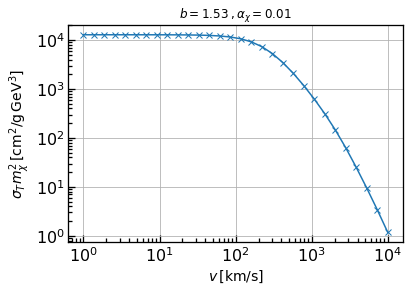

In [19]:
plt.plot(vs*c, sigmam2, "x-")
plt.loglog()
plt.xlabel('$v\\,\\mathrm{[km/s]}$', fontsize=14)
plt.ylabel(r'$\sigma_T m_\chi^2\,\mathrm{[cm^2/g\, GeV^3]}$', fontsize=14)
plt.title(r'$b={}\,, \alpha_\chi={}$'.format(b, alphaX))
plt.grid(True)
#plt.savefig('../plot/dirac_6.pdf', transparent=True)

In [20]:
mX = 200
mphi = 1e-3
alphaX = 1e-2
v = 1000/c
sign = 1.0

a = v/2/alphaX
b = alphaX*mX/mphi

delta_arr, xsect_k2_arr, L = xsect_k2_dirac(a, b, sign, max_L=400, tol=0.01, tol_convergence=0.01, eval_L=1500, verbose=True)

10 11.671342745604091 0.41600734364687253
20 17.517466257798944 1.5661681876510332
30 21.043565875220608 0.3800565387589635
40 23.565443434071195 -0.4657564938201374
50 25.482183370740664 -1.1156306899548716
60 27.06138398026429 1.4928179771478298
70 28.352375814614376 1.049802096200108
80 29.491484938157825 0.662912592104816
90 30.47708847117444 0.325334748505636
100 31.3351848629901 0.027701099096876885
110 32.090000751248105 -0.23735275475445733
120 32.807710561526484 -0.4834887004404153
130 33.44774943705287 -0.7057325585254978
140 34.048679057437134 -0.9126135582535739
150 34.57605004777433 -1.0978266510885557
160 35.08695286007153 -1.2739306694917856
170 35.58329449204813 -1.4409867291876233
180 36.08388228899512 1.537673224094125
190 36.547723522299904 1.3879178256235678
200 36.999532336083625 1.2447216914232135
210 37.427683002322375 1.1110905852322377
220 37.909074542357395 0.9732190584527876
230 38.426290145849556 0.8374605675479909
240 39.15104499101692 0.675955221660165
250

Text(0, 0.5, '$\\sigma_T m_\\chi^2\\,\\mathrm{[cm^2/g\\, GeV^3]}$')

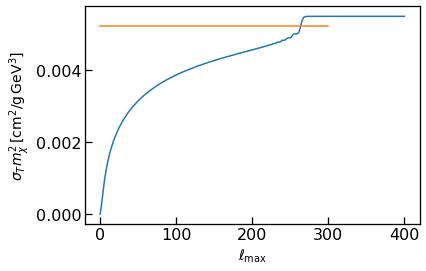

In [22]:
sigmam = np.array(xsect_k2_arr)*16*np.pi/mX**3/v**2 * unit_converter
plt.plot(sigmam)
sigmam3 = xsectm_clas_dirac(a, b, alphaX,  sign)/mX**3 * unit_converter
plt.plot([0,300], [sigmam3, sigmam3])
plt.xlabel(r'$\ell_{\mathrm{max}}$', fontsize=14)
plt.ylabel(r'$\sigma_T m_\chi^2\,\mathrm{[cm^2/g\, GeV^3]}$', fontsize=14)
#plt.savefig('../plot/crosscheck_clas.pdf')

Good at least $\ell \lesssim 250$